# Classification Model for SketchRNN

In [1]:
!pip3 install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in ./venv/lib/python3.8/site-packages (3.1.0)


In [2]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [3]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [4]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [5]:
import os

In [6]:
quickdraw_dir = filepath[:-len(FILENAME)]
train_files = [(quickdraw_dir + f) for f in os.listdir(quickdraw_dir) if f.startswith('training.tfrecord-')]
eval_files = [(quickdraw_dir + f) for f in os.listdir(quickdraw_dir) if f.startswith('eval.tfrecord-')]

In [7]:
train_files

['/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010']

In [8]:
eval_files

['/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/home/shrey/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [9]:
with open(quickdraw_dir + 'training.tfrecord.classes') as training_classes_file:
    training_classes = training_classes_file.readlines()
    
with open(quickdraw_dir + 'eval.tfrecord.classes') as test_classes_file:
    test_classes = test_classes_file.readlines()

In [10]:
assert training_classes == test_classes
class_names = [name.strip().lower() for name in training_classes]

In [11]:
print(sorted(class_names))

['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 'dolphin', 

In [12]:
def parse(data_batch):
    feature_descrition = {
        'ink' : tf.io.VarLenFeature(dtype = tf.float32),
        'shape' : tf.io.FixedLenFeature([2], dtype = tf.int64),
        'class_index' : tf.io.FixedLenFeature([1], dtype = tf.int64)
    }
    
    examples = tf.io.parse_example(data_batch, feature_descrition)
    flat_sketches = tf.sparse.to_dense(examples['ink'])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1 , 3])
    lengths = examples['shape'][:, 0]
    labels = examples['class_index'][:, 0]
    return sketches, lengths, labels

In [13]:
def quickdraw_dataset(filepaths, batch_size = 32, shuffle_buffer_size = None,
                      n_parse_threads=2, n_read_threads=2, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls = n_parse_threads)
    return dataset.prefetch(1)

In [14]:
train_set = quickdraw_dataset(train_files,batch_size = 32,shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [15]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.05511811  0.35265702  0.        ]
  [-0.02755906  0.26086953  0.        ]
  [-0.00393701  0.23188406  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.29411766  0.10502279  0.        ]
  [ 0.06666666  0.00913244  0.        ]
  [ 0.31764707  0.01826483  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.07843137  0.01052636  0.        ]
  [-0.19607842 -0.04210532  0.        ]
  [-0.17647058 -0.32631576  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.00784314  0.07643312  0.        ]
  [ 0.02352941  0.03821659  0.        ]
  [ 0.12156863  0.03821653  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

In [16]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

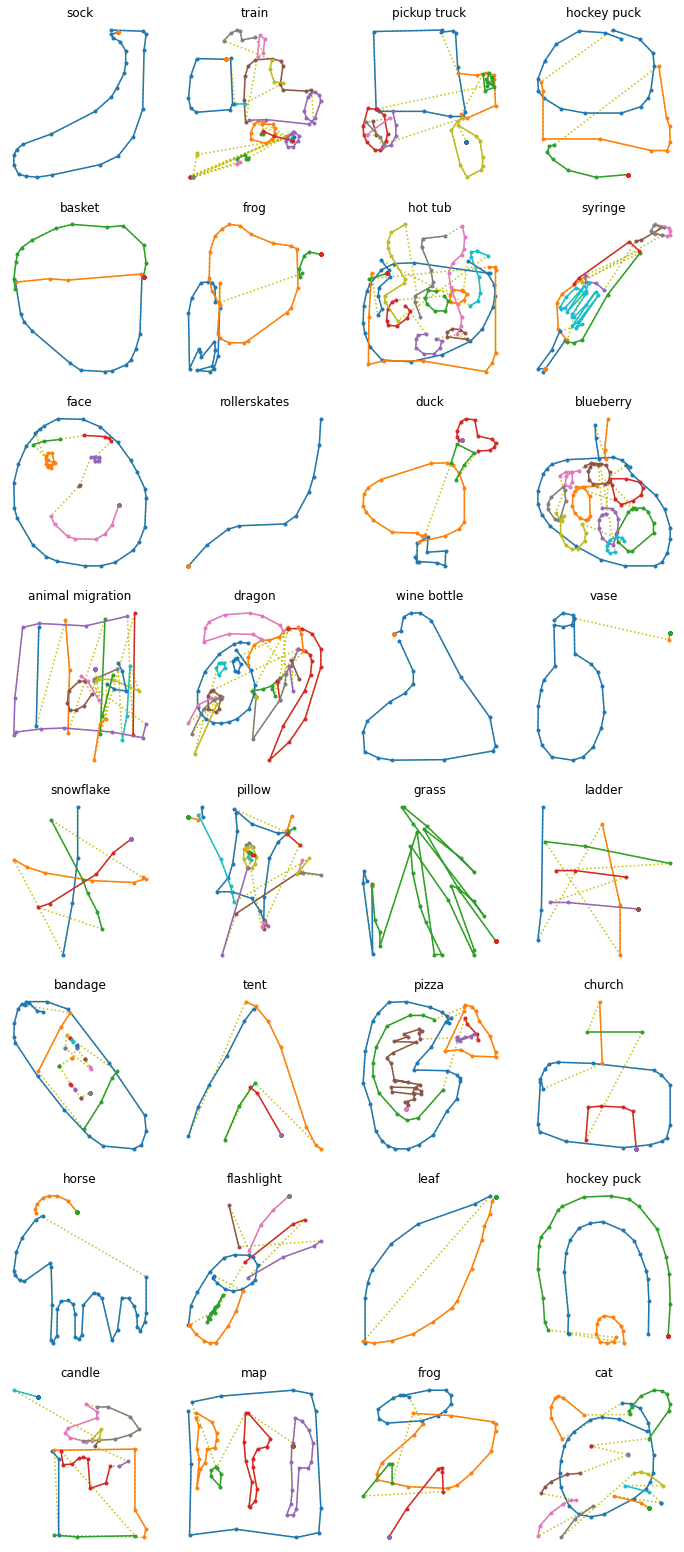

In [17]:
def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch, label)
    plt.show()
for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

Most sketches are composed of less than 100 points:

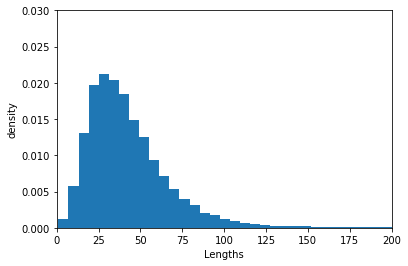

In [18]:
lengths = np.concatenate([lengths for _,lengths,_ in train_set.take(1000)])
plt.hist(lengths, bins=150, density = True)
plt.axis([0,200,0,0.03])
plt.xlabel('Lengths')
plt.ylabel('density')
plt.show()

In [19]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

In [20]:
cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [21]:
model = keras.models.Sequential([
    keras.layers.Conv1D(16, kernel_size= 5, strides=2, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(32, kernel_size= 5, strides=2, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size= 5, strides=2, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])

In [23]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='nadam',
             metrics = ['accuracy','sparse_top_k_categorical_accuracy'])
history = model.fit(cropped_train_set, epochs = 4, validation_data=cropped_valid_set)

Epoch 1/4
107813/107813 [==============================] - 2684s 25ms/step - loss: 2.2901 - accuracy: 0.4566 - sparse_top_k_categorical_accuracy: 0.7372 - val_loss: 1.8554 - val_accuracy: 0.5458 - val_sparse_top_k_categorical_accuracy: 0.8138
Epoch 2/4
107813/107813 [==============================] - 2704s 25ms/step - loss: 1.7953 - accuracy: 0.5580 - sparse_top_k_categorical_accuracy: 0.8223 - val_loss: 1.6967 - val_accuracy: 0.5802 - val_sparse_top_k_categorical_accuracy: 0.8378
Epoch 3/4
107813/107813 [==============================] - 2741s 25ms/step - loss: 1.6734 - accuracy: 0.5847 - sparse_top_k_categorical_accuracy: 0.8403 - val_loss: 1.6440 - val_accuracy: 0.5927 - val_sparse_top_k_categorical_accuracy: 0.8460
Epoch 4/4
107813/107813 [==============================] - 2762s 26ms/step - loss: 1.6082 - accuracy: 0.5993 - sparse_top_k_categorical_accuracy: 0.8497 - val_loss: 1.5929 - val_accuracy: 0.6051 - val_sparse_top_k_categorical_accuracy: 0.8531


In [38]:
y_probas = model.predict(cropped_test_set)

In [37]:
y_test = np.concatenate([labels for _, _, labels in test_set])

In [39]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test[... , np.newaxis], y_probas))

0.853917

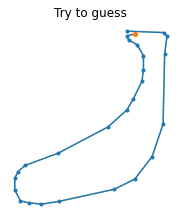

Top-5 predictions:
  1. sock 88.659%
  2. boomerang 3.316%
  3. hockey stick 1.835%
  4. shoe 1.327%
  5. foot 1.274%
Answer: sock


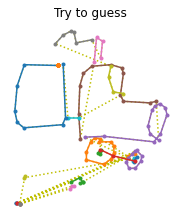

Top-5 predictions:
  1. beach 15.035%
  2. train 14.877%
  3. police car 12.543%
  4. sink 4.991%
  5. cake 4.445%
Answer: train


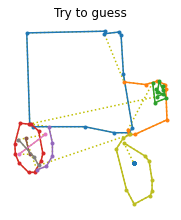

Top-5 predictions:
  1. cannon 19.138%
  2. pickup truck 8.047%
  3. bulldozer 7.898%
  4. stereo 7.352%
  5. truck 5.138%
Answer: pickup truck


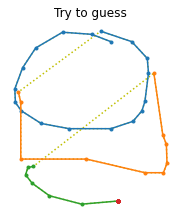

Top-5 predictions:
  1. hockey puck 52.028%
  2. hot tub 16.209%
  3. bathtub 6.977%
  4. bottlecap 3.884%
  5. pool 2.623%
Answer: hockey puck


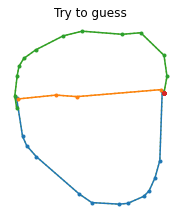

Top-5 predictions:
  1. bucket 83.506%
  2. basket 6.503%
  3. hot dog 4.542%
  4. bathtub 1.268%
  5. paint can 0.810%
Answer: basket


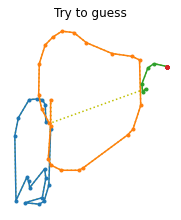

Top-5 predictions:
  1. frog 38.062%
  2. rhinoceros 9.799%
  3. elephant 8.554%
  4. drill 3.722%
  5. bear 3.681%
Answer: frog


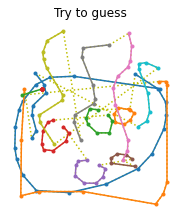

Top-5 predictions:
  1. string bean 15.681%
  2. crab 12.564%
  3. submarine 11.187%
  4. snorkel 4.430%
  5. cow 4.344%
Answer: hot tub


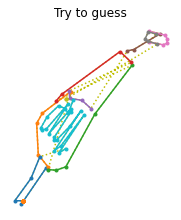

Top-5 predictions:
  1. syringe 51.521%
  2. toothpaste 7.450%
  3. drill 5.296%
  4. screwdriver 5.147%
  5. marker 3.132%
Answer: syringe


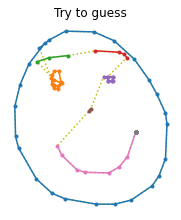

Top-5 predictions:
  1. face 93.096%
  2. smiley face 2.960%
  3. clock 0.845%
  4. cookie 0.356%
  5. potato 0.274%
Answer: face


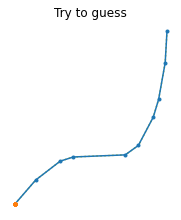

Top-5 predictions:
  1. waterslide 20.244%
  2. elbow 12.967%
  3. leg 7.671%
  4. hockey stick 7.317%
  5. banana 7.141%
Answer: rollerskates


In [40]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [41]:
model.save("my_sketchrnn")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_sketchrnn/assets
